In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn import metrics 
from scipy.spatial.distance import cdist
import pickle
from flask import Flask, request, json, jsonify
import requests
import json
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
 #Reading dataset
df = pd.read_excel(r'ProjectDataSet.xlsx')

In [3]:
#Display dataset
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Upon reasearch, I have found the descriptions for each of the variables from the following website that contains the dataset: https://archive.ics.uci.edu/dataset/352/online+retail

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter ‘c’, it indicates a cancellation.\
StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.\
Description: Product (item) name. Nominal.\
Quantity: The quantities of each product (item) per transaction. Numeric.\
InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated.\
UnitPrice: Unit price. Numeric, Product price per unit in sterling.\
CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.\
Country: Country name. Nominal, the name of the country where each customer resides.

# Data pre-processing

In [4]:
#Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Dataframe has 541909 rows and 8 columns.

In [5]:
#Drop duplicates
df_dups = df.drop_duplicates() #Dropping duplicates
dups = df.shape[0] - df_dups.shape[0] #Counting number of duplicates
dups_per = round(dups/df.shape[0], 2) * 100 #Converting to percentage

print("Below is the dataset after dropping duplicates:")
df_dups.info()

print()
print(f"There remains {df_dups.shape[0]} rows after dropping the duplicated rows, \
removing {dups} duplicates which is about {dups_per}%. of the[] total     population.")

Below is the dataset after dropping duplicates:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    536641 non-null  object        
 1   StockCode    536641 non-null  object        
 2   Description  535187 non-null  object        
 3   Quantity     536641 non-null  int64         
 4   InvoiceDate  536641 non-null  datetime64[ns]
 5   UnitPrice    536641 non-null  float64       
 6   CustomerID   401604 non-null  float64       
 7   Country      536641 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.8+ MB

There remains 536641 rows after dropping the duplicated rows, removing 5268 duplicates which is about 1.0%. of the[] total     population.


From the earlier research on the dataset, it is found that this dataset is a UK-based and registered non-store online retail. Let's check the percentage of each country to see if it is worth keeping.

In [6]:
#Check country precentages
country_count = df_dups['Country'].value_counts() #Checking total rows of each country
per_country = round((country_count / country_count.sum()) * 100, 2) #Converting to percentage

print(per_country)
print()
print("We can see that 91.36% of the data is from the United Kingdom so we will only use data from that country. \
Not only do we use   United Kingdom only, we can remove the country column as it does not give any information as \
it is all United Kingdom.")

United Kingdom          91.36
Germany                  1.77
France                   1.59
EIRE                     1.53
Spain                    0.47
Netherlands              0.44
Belgium                  0.39
Switzerland              0.37
Portugal                 0.28
Australia                0.23
Norway                   0.20
Italy                    0.15
Channel Islands          0.14
Finland                  0.13
Cyprus                   0.11
Sweden                   0.09
Unspecified              0.08
Austria                  0.07
Denmark                  0.07
Japan                    0.07
Poland                   0.06
Israel                   0.05
USA                      0.05
Hong Kong                0.05
Singapore                0.04
Iceland                  0.03
Canada                   0.03
Greece                   0.03
Malta                    0.02
United Arab Emirates     0.01
European Community       0.01
RSA                      0.01
Lebanon                  0.01
Lithuania 

In [7]:
df_dups = df_dups[df_dups['Country'] == 'United Kingdom']
df_country_remove = df_dups.drop('Country', axis = 1) #Dropping country

print("Below is the dataset after dropping country:")
df_country_remove.info()

print()
print("Now there remains only 490300 rows and 7 columns.")

Below is the dataset after dropping country:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 490300 entries, 0 to 541893
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    490300 non-null  object        
 1   StockCode    490300 non-null  object        
 2   Description  488846 non-null  object        
 3   Quantity     490300 non-null  int64         
 4   InvoiceDate  490300 non-null  datetime64[ns]
 5   UnitPrice    490300 non-null  float64       
 6   CustomerID   356728 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 29.9+ MB

Now there remains only 490300 rows and 7 columns.


Next we will look at removing cancelled orders as it is considered noise that affects the data.

In [8]:
#Removing cancelled orders
df_country_remove['InvoiceNo'] = df_country_remove['InvoiceNo'].astype(str)#Changing datatype to string, somehow was float
df_remove_cancel_orders = df_country_remove[~df_country_remove['InvoiceNo']\
                                             .str.startswith('C')] #Remove all cancelled invoice numbers

print(f"There were {df_country_remove['InvoiceNo'].str.startswith('C').sum()} cancelled orders which consisted of \
{round(df_country_remove['InvoiceNo'].str.startswith('C').sum()/df_country_remove.shape[0] * 100, 2)}% of \
total dataset.")
print()
print("Below is the dataset after removing cancelled orders:")
df_remove_cancel_orders.info()

There were 7821 cancelled orders which consisted of 1.6% of total dataset.

Below is the dataset after removing cancelled orders:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 482479 entries, 0 to 541893
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    482479 non-null  object        
 1   StockCode    482479 non-null  object        
 2   Description  481025 non-null  object        
 3   Quantity     482479 non-null  int64         
 4   InvoiceDate  482479 non-null  datetime64[ns]
 5   UnitPrice    482479 non-null  float64       
 6   CustomerID   349227 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 29.4+ MB


In [9]:
#Remove negative quantity values which includes cancelled orders and data entry mistakes
df_positive_quantity = df_remove_cancel_orders[df_remove_cancel_orders['Quantity'] >= 0]

print("Below is the dataset after removing negative quantity:")
df_positive_quantity.info()

Below is the dataset after removing negative quantity:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 481143 entries, 0 to 541893
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    481143 non-null  object        
 1   StockCode    481143 non-null  object        
 2   Description  480551 non-null  object        
 3   Quantity     481143 non-null  int64         
 4   InvoiceDate  481143 non-null  datetime64[ns]
 5   UnitPrice    481143 non-null  float64       
 6   CustomerID   349227 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 29.4+ MB


In [10]:
#Checking null values for each column
print(df_positive_quantity.isna().sum())
print()
print('I am planning to remove all the rows with value null as \
we have a lot of data anyway so it will not affect too much.')

InvoiceNo           0
StockCode           0
Description       592
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     131916
dtype: int64

I am planning to remove all the rows with value null as we have a lot of data anyway so it will not affect too much.


In [11]:
df_row_dropped = df_positive_quantity.dropna() #Drop null values
print('Dimension after dropping nulls: ' + str(df_row_dropped.shape))
df_row_dropped.isna().sum() #Check if any null remains

Dimension after dropping nulls: (349227, 7)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
dtype: int64

In [12]:
numeric = df_row_dropped.select_dtypes(include = ['int64', 'float64']) #Saving numerical data for column names
categorical = df_row_dropped.select_dtypes(include = ['object']) #Saving categorical data for column names
temporal = df_row_dropped.select_dtypes(include = ['datetime64[ns]']) #Saving time based data for column names

## There will be no splitting of training and testing at this stage as clustering does not require it to be split because the data is not labeled. It will be discussed at a later stage.

### Numerical data analysis

In [13]:
#Checking for infinity
for column in numeric.columns:
    inf = np.isinf(df_row_dropped[column]).values.sum()
    print(column + " contains " + str(inf) + " infinite values.")

Quantity contains 0 infinite values.
UnitPrice contains 0 infinite values.
CustomerID contains 0 infinite values.


In [14]:
#Count number of zeros in all columns of Dataframe
zeros = []
print("Zero counts:")

for column_name in numeric.columns:
    column = df_row_dropped[column_name]
    # Get the count of zeros in column 
    count = (column == 0).sum()
    zeros.append(count)
    print('Count of zeros in column', column_name, 'is:', count)

Zero counts:
Count of zeros in column Quantity is: 0
Count of zeros in column UnitPrice is: 24
Count of zeros in column CustomerID is: 0


In [15]:
#Checking to see if product being price 0 makes sense
unit_zero = df_row_dropped['UnitPrice'] == 0 #Selecting rows with unit price 0
zero_check = df_row_dropped[unit_zero]
print(f"Number of unique products: {zero_check['Description'].nunique()}") #Number of unique products with unit price 0
print(zero_check['Description'].unique()) #Name of unique products

Number of unique products: 22
['ADVENT CALENDAR GINGHAM SACK' 'PAPER BUNTING RETROSPOT'
 'PLASTERS IN TIN SKULLS' 'ORGANISER WOOD ANTIQUE WHITE '
 'FAIRY CAKES NOTEBOOK A6 SIZE' 'CERAMIC BOWL WITH LOVE HEART DESIGN'
 'MINI CAKE STAND  HANGING STRAWBERY' 'HEART GARLAND RUSTIC PADDED'
 'PARTY BUNTING' ' OVAL WALL MIRROR DIAMANTE ' 'Manual'
 'PADS TO MATCH ALL CUSHIONS' 'GLASS CLOCHE SMALL'
 'PASTEL COLOUR HONEYCOMB FAN' 'CHRISTMAS PUDDING TRINKET POT '
 'RED KITCHEN SCALES' "CHILDREN'S APRON DOLLY GIRL "
 'MINI LIGHTS WOODLAND MUSHROOMS' 'SET OF 9 BLACK SKULL BALLOONS'
 'PAPER BUNTING VINTAGE PAISLEY' 'HANGING METAL HEART LANTERN'
 'ASSTD DESIGN 3D PAPER STICKERS']


The price of the products above being 0 does not make sense. Crosschecking with the excel file was done as well to make sure the price was not 0 for majority of the products. The 24 rows that consist of unit price 0 will be removed. I am assuming this is wrongly entered data. This will be a safer approach than assuming these products are free.

In [16]:
zeros = []
df_unit_price_removed = df_row_dropped[df_row_dropped['UnitPrice'] != 0] #Remove all rows with unit price 0
for column_name in df_unit_price_removed.columns: #Double checking for all columns
    column = df_unit_price_removed[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    zeros.append(count)
    print('Count of zeros in column', column_name, 'is:', count)
    
print()
print("Below is the dataset after unit price 0 is removed:")
df_unit_price_removed.info()

Count of zeros in column InvoiceNo is: 0
Count of zeros in column StockCode is: 0
Count of zeros in column Description is: 0
Count of zeros in column Quantity is: 0
Count of zeros in column InvoiceDate is: 0
Count of zeros in column UnitPrice is: 0
Count of zeros in column CustomerID is: 0

Below is the dataset after unit price 0 is removed:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 349203 entries, 0 to 541893
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    349203 non-null  object        
 1   StockCode    349203 non-null  object        
 2   Description  349203 non-null  object        
 3   Quantity     349203 non-null  int64         
 4   InvoiceDate  349203 non-null  datetime64[ns]
 5   UnitPrice    349203 non-null  float64       
 6   CustomerID   349203 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 21.3+ MB


Now I will check for outliers and remove them for the numerical columns. I will use z-score to measure the outliers. 99.7% of the data points lie between +/- 3 standard deviation (using Gaussian Distribution approach).

In [17]:
def outliers(data, feature):
    z_scores = np.abs(stats.zscore(data[feature]))
    outliers = data[z_scores > 3][feature]
    sns.boxplot(data[feature])
    plt.show()
    # Delete outliers
    if not outliers.empty:
        n_outliers = len(outliers)
        print("Outliers found in column at index:", outliers.index)
        data.drop(outliers.index, inplace=True)
        print(str(n_outliers) + " outliers have been removed from the dataset for " + feature + '.')
    else:
        print("No outliers found for " + feature  + '.')
    print(data.shape)

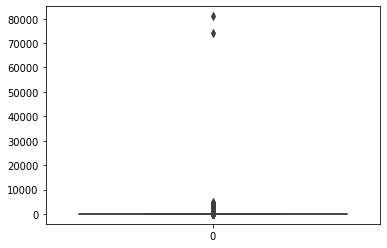

Outliers found in column at index: Int64Index([   730,   3917,   4850,   4945,   4946,   9745,  16427,  16428,
             16435,  16436,
            ...
            533737, 533738, 533739, 533741, 533812, 537883, 540061, 540070,
            540071, 540421],
           dtype='int64', length=303)
303 outliers have been removed from the dataset for Quantity.
(348900, 7)


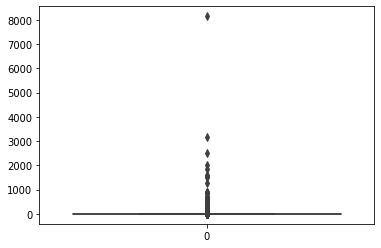

Outliers found in column at index: Int64Index([   246,   3790,   4989,  19428,  19429,  25168,  28866,  28902,
             31613,  31614,
            ...
            468546, 471340, 473150, 479081, 490300, 493383, 494728, 508459,
            526015, 528082],
           dtype='int64', length=179)
179 outliers have been removed from the dataset for UnitPrice.
(348721, 7)


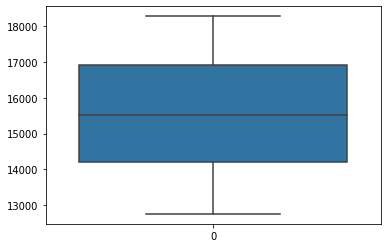

No outliers found for CustomerID.
(348721, 7)
Below is the dataset after removing outliers:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 348721 entries, 0 to 541893
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    348721 non-null  object        
 1   StockCode    348721 non-null  object        
 2   Description  348721 non-null  object        
 3   Quantity     348721 non-null  int64         
 4   InvoiceDate  348721 non-null  datetime64[ns]
 5   UnitPrice    348721 non-null  float64       
 6   CustomerID   348721 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 29.3+ MB


In [18]:
#Outliers removal
for column in numeric.columns:
    outliers(df_unit_price_removed, column)
    
print('Below is the dataset after removing outliers:')
df_unit_price_removed.info()

This will conclude the cleaning for the numerical data.

### Categorical data analysis

In [19]:
for column in categorical.columns:
    print(column + " has " + str(df_unit_price_removed[column].nunique()) + " unique values.")

InvoiceNo has 16533 unique values.
StockCode has 3637 unique values.
Description has 3835 unique values.


In [20]:
#InvoiceNo Analysis
average_purchase_per_invoice = df_unit_price_removed.shape[0]/df_unit_price_removed['InvoiceNo'].nunique()
print(f'Per invoice, there are average {round(average_purchase_per_invoice)} number of items being bought.')

Per invoice, there are average 21 number of items being bought.


For Stock Code variable, I filtered the excel sheet to see only the unique features to see if there any that stand out. From the anaylsis, these few stock codes are the ones that stand out:
- M = Manual
- BANK CHARGES = Bank Charges
- C2 = Carriage
- POST = Postage
- PADS = PADS TO MATCH ALL CUSHIONS
- DOT = DOTCOM POSTAGE

These descriptions do not seem like products so I will remove them to prevent any potential problems.

In [21]:
#StockCode Analysis
weird_stockcode = ['M', 'BANK CHARGES', 'C2', 'POST', 'PADS', 'DOT'] #StockCode of the weird codes
sc_sum = 0 #Set variable to count how many rows total

for sc in weird_stockcode: #Check for each row
    print(f"Number of rows with description {sc} is {str(df_unit_price_removed['StockCode'].value_counts()[sc])}.")
    sc_sum = sc_sum + df_unit_price_removed['StockCode'].value_counts()[sc]

print()
print(f"Total num of weird stock codes are {sc_sum}.")
print('Below is the dataset after the weird stock codes are removed:')
df_categorical_clean = df_unit_price_removed[~df_unit_price_removed['StockCode'].isin(weird_stockcode)] 
#Remove all weird stock code 
df_categorical_clean.info()

Number of rows with description M is 219.
Number of rows with description BANK CHARGES is 12.
Number of rows with description C2 is 30.
Number of rows with description POST is 25.
Number of rows with description PADS is 3.
Number of rows with description DOT is 3.

Total num of weird stock codes are 292.
Below is the dataset after the weird stock codes are removed:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 348429 entries, 0 to 541893
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    348429 non-null  object        
 1   StockCode    348429 non-null  object        
 2   Description  348429 non-null  object        
 3   Quantity     348429 non-null  int64         
 4   InvoiceDate  348429 non-null  datetime64[ns]
 5   UnitPrice    348429 non-null  float64       
 6   CustomerID   348429 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage:

For Description variable, I filtered the excel sheet to see only the unique features to see if there any that stand out. From the anaylsis, there are no weird descriptions. This could have been solved in the earlier cleaning of the stock code.

## Temporal data analysis

After quickly scrolling through the excel file given, it can be seen that the final month of data is incomplete, we will thus remove that month which is December 2011.

In [22]:
incomplete_month = df_categorical_clean[df_categorical_clean['InvoiceDate'] >= '2011-12'].shape[0] #Check incomplete month
print(f"Number of rows in the month December 2011 that is not a complete month is {incomplete_month}.")

print()
print('Below is the dataset after removing incomplete month of data:')

df_month_removed = df_categorical_clean[df_categorical_clean['InvoiceDate'] < '2011-12-01'] #Filter incomplete month out
df_month_removed.info()

Number of rows in the month December 2011 that is not a complete month is 15493.

Below is the dataset after removing incomplete month of data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 332936 entries, 0 to 516368
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    332936 non-null  object        
 1   StockCode    332936 non-null  object        
 2   Description  332936 non-null  object        
 3   Quantity     332936 non-null  int64         
 4   InvoiceDate  332936 non-null  datetime64[ns]
 5   UnitPrice    332936 non-null  float64       
 6   CustomerID   332936 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 20.3+ MB


# Feature Engineering

First let's look at the distribution of the numerical variables.

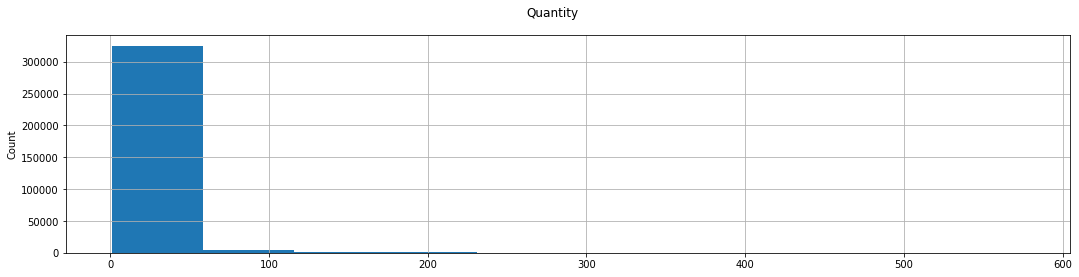

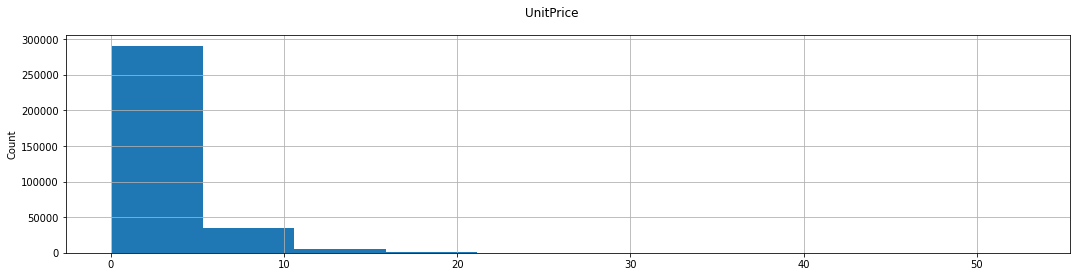

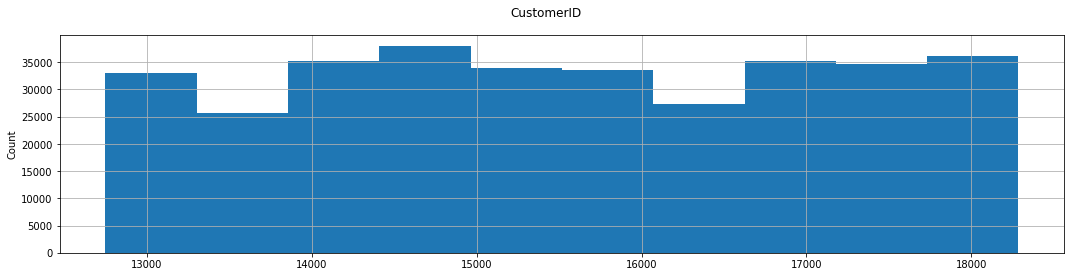

In [23]:
for column in numeric.columns: #Check skewness of all numerical variables
    plt.figure(figsize=(18,4))
    plt.suptitle(column)
    plt.ylabel('Count')
    df_month_removed[column].hist(grid = True)

We can see that quantity and unit price are heavily right skewed. CustomerID would not matter much in terms of skewness because it is meant to use as an identifier to identify a customer. In fact, we should actually check how many unique CustomerID there are so we know how many buyers we have.

In [24]:
print(f"There are {df_month_removed['CustomerID'].nunique()} number of customers.")

There are 3867 number of customers.


Next let's look at the categorical variables.

In [25]:
#Check unique values for each categorical columns
print("List of unique categorical factors: ")
print()

for column in categorical.columns:
    print(column + ": ")
    print(f"Number of unique features for column {column} is {df_month_removed[column].nunique()}.")
    print(df_month_removed[column].value_counts())
    print()

List of unique categorical factors: 

InvoiceNo: 
Number of unique features for column InvoiceNo is 15790.
576339    541
579196    532
578270    441
573576    434
567656    420
         ... 
545694      1
557767      1
574668      1
574666      1
564382      1
Name: InvoiceNo, Length: 15790, dtype: int64

StockCode: 
Number of unique features for column StockCode is 3623.
85123A    1876
85099B    1422
22423     1379
47566     1285
84879     1275
          ... 
84201C       1
90054        1
35645        1
90071        1
90125E       1
Name: StockCode, Length: 3623, dtype: int64

Description: 
Number of unique features for column Description is 3820.
WHITE HANGING HEART T-LIGHT HOLDER    1876
JUMBO BAG RED RETROSPOT               1422
REGENCY CAKESTAND 3 TIER              1379
PARTY BUNTING                         1285
ASSORTED COLOUR BIRD ORNAMENT         1275
                                      ... 
GREEN ENAMEL FLOWER HAIR TIE             1
FIRE POLISHED GLASS BRACELET BLACK       1

Now that we have done a quick analysis on the features, I will run a correlation check to see if any of the variables are correlated.

In [26]:
df_month_removed.corr()

,Quantity,UnitPrice,CustomerID
Quantity,1.000000,-0.160974,-0.015966
UnitPrice,-0.160974,1.000000,-0.011715
CustomerID,-0.015966,-0.011715,1.000000


From the above table, we can see that none of the variables are correlated to each other. Next we will first create new variables that could be of use then group the CustomerID together as we are trying to see the customers behaviour. StockCode and Description will probably be removed as it will not tell us customer behaviour. It would be possible to use it if we have the brand it belongs too. InvoiceDate can be used for the frequency of transactions so we will keep that in mind. Let's focus on Quantity, UnitPrice and the number of orders that have been made per customer.

In [27]:
#Create total price column
df_month_removed['Sales'] = df_month_removed['Quantity'] * df_month_removed['UnitPrice']

In [28]:
# Create individual customer data
df_customers = df_month_removed.groupby('CustomerID').agg({'Sales': sum,
                                             'InvoiceNo': lambda x: x.nunique()})
df_customers.columns = ['TotalSales', 'OrderCount']
df_customers['AvgSalesPerOrder'] = df_customers['TotalSales'] / df_customers['OrderCount']

So in the cell above, what we do is create total sales, order count, and average sales per order for an individual. These will be the main features I will use to segment the customers by their spending behaviour.

In [29]:
df_customers.info()
print("As we checked earlier, there are 3867 unique buyers.")

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3867 entries, 12747.0 to 18287.0
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TotalSales        3867 non-null   float64
 1   OrderCount        3867 non-null   int64  
 2   AvgSalesPerOrder  3867 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 120.8 KB
As we checked earlier, there are 3867 unique buyers.


In [30]:
df_customers.head()

,TotalSales,OrderCount,AvgSalesPerOrder
CustomerID,,,
12747.0,3757.51,10,375.751000
12748.0,30652.63,197,155.597107
12749.0,3277.82,4,819.455000
12820.0,731.99,3,243.996667
12821.0,92.72,1,92.720000


In [31]:
df_customers.describe()

,TotalSales,OrderCount,AvgSalesPerOrder
count,3867.000000,3867.000000,3867.000000
mean,1641.117773,4.083269,336.179580
std,5706.770265,6.871807,282.585662
min,2.900000,1.000000,2.900000
25%,287.895000,1.000000,171.302500
50%,621.750000,2.000000,276.397500
75%,1492.580000,4.000000,405.866667
max,229580.160000,197.000000,4027.722105


Skewness for TotalSales: 22.00560812461294
Skewness for OrderCount: 10.711415717332722
Skewness for AvgSalesPerOrder: 3.956088710943716


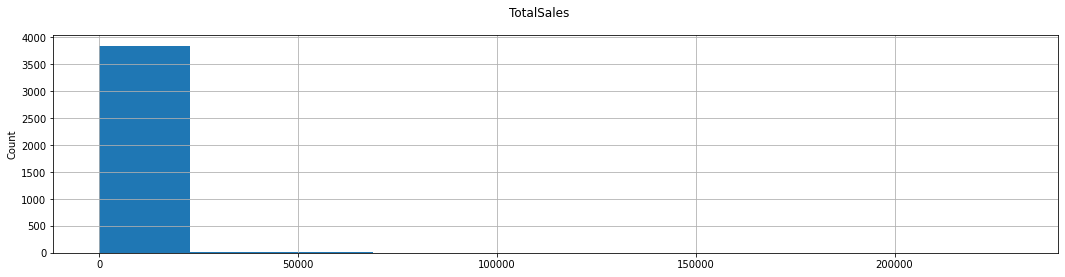

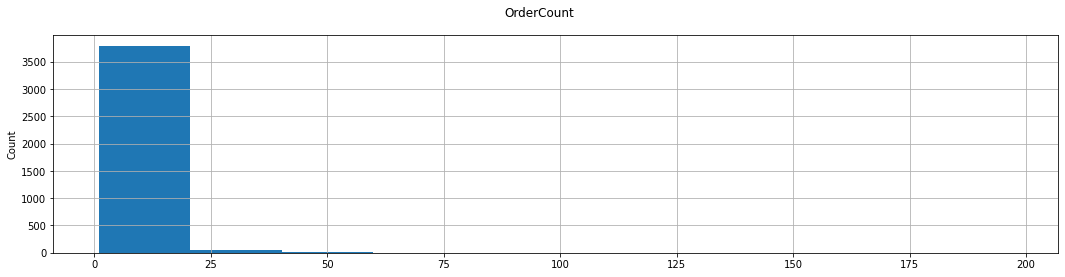

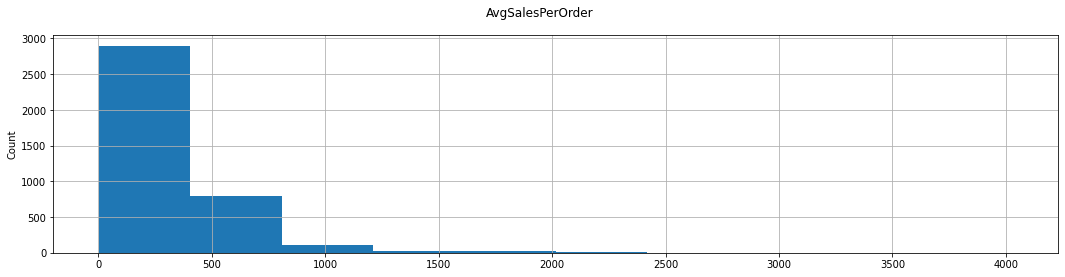

In [32]:
#Check distribution of customers
for column in df_customers.columns:
    plt.figure(figsize=(18,4))
    plt.suptitle(column)
    plt.ylabel('Count')
    df_customers[column].hist(grid = True)
    print(f"Skewness for {column}: " + str(df_customers[column].skew()))

In [33]:
df_customers.head(10)

,TotalSales,OrderCount,AvgSalesPerOrder
CustomerID,,,
12747.0,3757.51,10,375.751000
12748.0,30652.63,197,155.597107
12749.0,3277.82,4,819.455000
12820.0,731.99,3,243.996667
12821.0,92.72,1,92.720000
12822.0,948.88,2,474.440000
12823.0,1759.50,5,351.900000
12824.0,397.12,1,397.120000
12826.0,1332.12,6,222.020000


Lets rank the customers according to how they perform in each category, the higher the rank(number) being better. I will use the method = 'first' as it provides a better scatter of the customers and give priority to the customer that has been with the store longer. For example, we can see that ID 12821 and 12824 has order count 1, but ID 12821 is a older customer, hence priotizing them.

In [34]:
df_rank = df_customers.rank(method='first')
df_rank.head(10)

,TotalSales,OrderCount,AvgSalesPerOrder
CustomerID,,,
12747.0,3567.0,3535.0,2746.0
12748.0,3848.0,3867.0,792.0
12749.0,3493.0,2575.0,3695.0
12820.0,2147.0,2112.0,1721.0
12821.0,134.0,1.0,228.0
12822.0,2436.0,1398.0,3192.0
12823.0,3062.0,2917.0,2590.0
12824.0,1431.0,2.0,2862.0
12826.0,2782.0,3124.0,1498.0


Skewness for TotalSales: 0.0
Skewness for OrderCount: 0.0
Skewness for AvgSalesPerOrder: 0.0


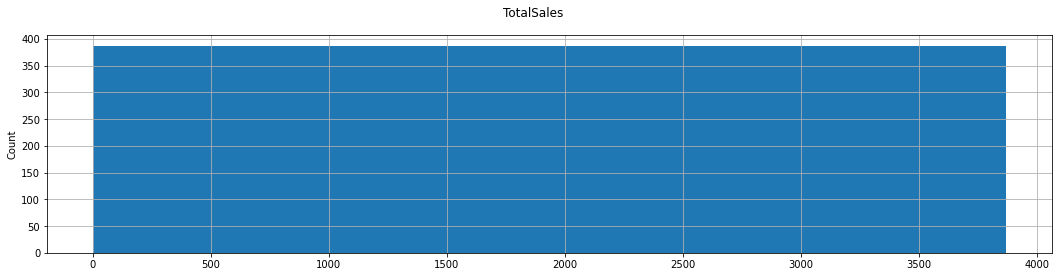

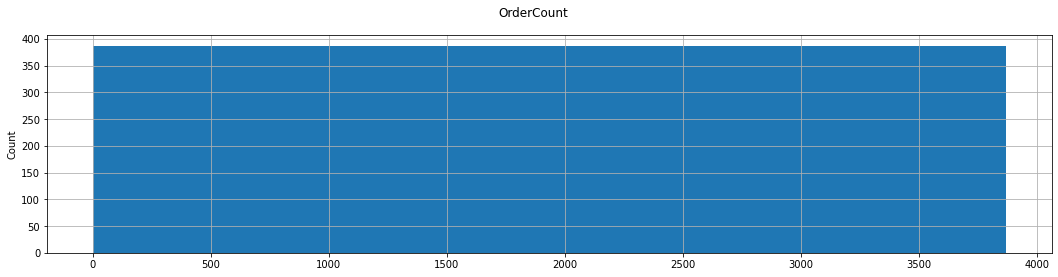

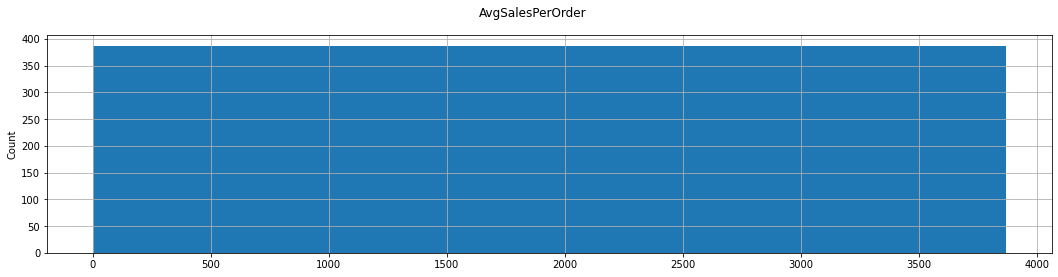

In [35]:
#Check distribution of customers
for column in df_rank.columns:
    plt.figure(figsize=(18,4))
    plt.suptitle(column)
    plt.ylabel('Count')
    df_rank[column].hist(grid = True)
    print(f"Skewness for {column}: " + str(df_rank[column].skew()))

After ranking the customers, there is no longer any skewness due to the nature of the rank function. I will however still scale the data as the range varies.

In [36]:
#Applying standard scaler
df_rank_ss = df_rank.copy()
ss = StandardScaler()
for column in df_rank_ss.columns:
    df_rank_ss[column] = ss.fit_transform(df_rank_ss[[column]])

In [37]:
#Checking data after standard scaler scaling
df_rank_ss.describe()

,TotalSales,OrderCount,AvgSalesPerOrder
count,3867.000000,3867.000000,3.867000e+03
mean,0.000000,0.000000,-3.674904e-18
std,1.000129,1.000129,1.000129e+00
min,-1.731603,-1.731603,-1.731603e+00
25%,-0.865801,-0.865801,-8.658015e-01
50%,0.000000,0.000000,0.000000e+00
75%,0.865801,0.865801,8.658015e-01
max,1.731603,1.731603,1.731603e+00


In [38]:
#Applying standard scaler
df_rank_mm = df_rank.copy()
mm = MinMaxScaler()
for column in df_rank_mm.columns:
    df_rank_mm[column] = mm.fit_transform(df_rank_mm[[column]])

In [39]:
#Checking data after min max scaling
df_rank_mm.describe()

,TotalSales,OrderCount,AvgSalesPerOrder
count,3867.000000,3867.000000,3867.000000
mean,0.500000,0.500000,0.500000
std,0.288787,0.288787,0.288787
min,0.000000,0.000000,0.000000
25%,0.250000,0.250000,0.250000
50%,0.500000,0.500000,0.500000
75%,0.750000,0.750000,0.750000
max,1.000000,1.000000,1.000000


I will try using data from both the StandardScaler scaling and MinMax scaling to see which one performs better.

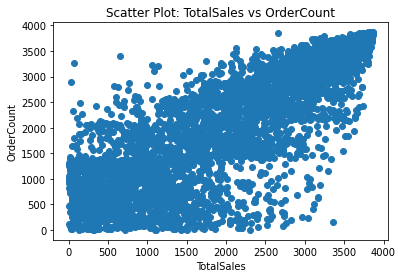

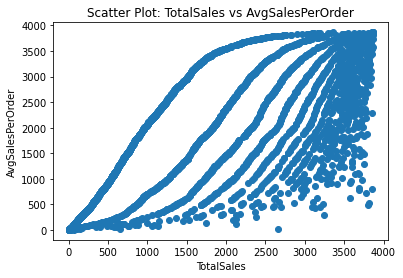

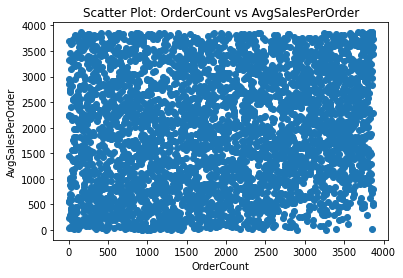

In [40]:
# Create scatter plots for each pair of variables
variables = df_rank.columns #Taking the 3 variables

for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        x = df_rank[variables[i]]
        y = df_rank[variables[j]]
        plt.scatter(x, y)
        plt.xlabel(variables[i])
        plt.ylabel(variables[j])
        plt.title(f'Scatter Plot: {variables[i]} vs {variables[j]}')
        plt.show()

# Model Development & Evaluation

## KMeans Algorithm

### Silhouette Score
Silhouette score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters. The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

Silhouette coefficient for 2 clusters: 0.434
Silhouette coefficient for 3 clusters: 0.416
Silhouette coefficient for 4 clusters: 0.417
Silhouette coefficient for 5 clusters: 0.383
Silhouette coefficient for 6 clusters: 0.383
Silhouette coefficient for 7 clusters: 0.381
Silhouette coefficient for 8 clusters: 0.384
Silhouette coefficient for 9 clusters: 0.379


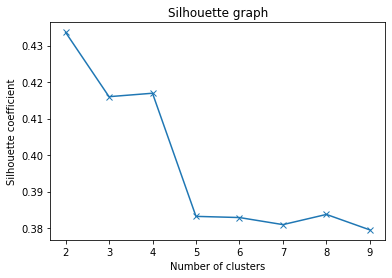


The best number of clusters using silhouette coefficient is 2 which has a score of 0.434.


In [41]:
# Calculate Silhouette coefficient to find optimal number of clusters
silhouette_km = []
K = range(2, 10)
for n_cluster in K:
    kmeans = KMeans(n_clusters = n_cluster,
                    random_state = 123,
                    max_iter = 400,
                    n_init = 20).fit(df_rank_ss[['TotalSales',
                                                  'OrderCount',
                                                  'AvgSalesPerOrder']])
    silhouette_avg = silhouette_score(df_rank_ss[['TotalSales',
                                                     'OrderCount',
                                                     'AvgSalesPerOrder']],
                                      kmeans.labels_)
    silhouette_km.append(silhouette_avg)
    print('Silhouette coefficient for %i clusters: %0.3f' % (n_cluster,
                                                             silhouette_avg))

#Plotting silhouette scores
plt.plot(K, silhouette_km, marker = 'x')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette graph')
plt.show()

print()
print(f'The best number of clusters using silhouette coefficient is \
{silhouette_km.index(max(silhouette_km)) + 2} \
which has a score of {round(max(silhouette_km), 3)}.')

### Davies-Bouldin index
The Davies-Bouldin index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. Zero is the lowest possible score. Values closer to zero indicate a better partition.

Davies-Bouldin score for 2 clusters: 0.906
Davies-Bouldin score for 3 clusters: 0.861
Davies-Bouldin score for 4 clusters: 0.793
Davies-Bouldin score for 5 clusters: 0.864
Davies-Bouldin score for 6 clusters: 0.856
Davies-Bouldin score for 7 clusters: 0.795
Davies-Bouldin score for 8 clusters: 0.797
Davies-Bouldin score for 9 clusters: 0.807


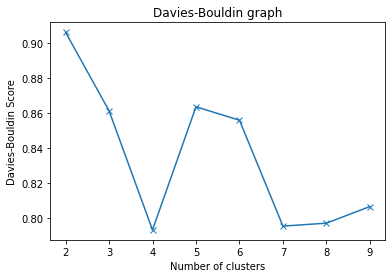


The best number of clusters using Davies-Bouldin score is 4 which has a score of 0.793.


In [42]:
# Calculate Davies-Bouldin score to find optimal number of clusters
davies_km = []
K = range(2, 10)
for n_cluster in K:
    kmeans = KMeans(n_clusters = n_cluster,
                    random_state = 123,
                    max_iter = 400,
                    n_init = 20).fit(df_rank_ss[['TotalSales',
                                                  'OrderCount',
                                                  'AvgSalesPerOrder']])
    davies_bouldin_avg = davies_bouldin_score(df_rank_ss[['TotalSales',
                                                     'OrderCount',
                                                     'AvgSalesPerOrder']],
                                            kmeans.labels_)
    davies_km.append(davies_bouldin_avg)
    print('Davies-Bouldin score for %i clusters: %0.3f' % (n_cluster,
                                                           davies_bouldin_avg))

#Plotting Davies-Bouldin scores
plt.plot(K, davies_km, marker = 'x')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin graph')
plt.show()
    
print()
print(f'The best number of clusters using Davies-Bouldin score is \
{davies_km.index(min(davies_km)) + 2} \
which has a score of {round(min(davies_km), 3)}.')

### Calinski-Harabasz score
A higher Calinski-Harabasz score relates to a model with better defined clusters.

Calinski-Harabasz score for 2 clusters: 4011.680
Calinski-Harabasz score for 3 clusters: 4006.566
Calinski-Harabasz score for 4 clusters: 4308.024
Calinski-Harabasz score for 5 clusters: 4085.259
Calinski-Harabasz score for 6 clusters: 4116.182
Calinski-Harabasz score for 7 clusters: 4142.750
Calinski-Harabasz score for 8 clusters: 4209.545
Calinski-Harabasz score for 9 clusters: 4244.977


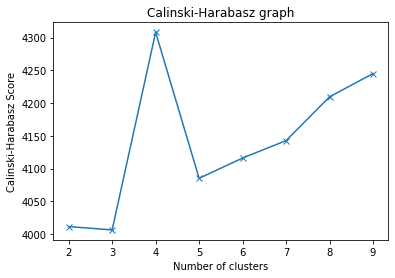


The best number of clusters using Calinski-Harabasz score is 4 which has a score of 4308.024.


In [43]:
# Calculate Calinski-Harabasz score to find optimal number of clusters
calinski_km = []
K = range(2, 10)
for n_cluster in K:
    kmeans = KMeans(n_clusters = n_cluster,
                    random_state = 123,
                    max_iter = 400,
                    n_init = 20).fit(df_rank_ss[['TotalSales',
                                                  'OrderCount',
                                                  'AvgSalesPerOrder']])
    calinski_harabasz_avg = calinski_harabasz_score(df_rank_ss[['TotalSales',
                                                     'OrderCount',
                                                     'AvgSalesPerOrder']],
                                            kmeans.labels_)
    calinski_km.append(calinski_harabasz_avg)
    print('Calinski-Harabasz score for %i clusters: %0.3f' % (n_cluster,
                                                           calinski_harabasz_avg))
    
#Plotting Calinski-Harabasz scores
plt.plot(K, calinski_km, marker = 'x')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz graph')
plt.show()

print()
print(f'The best number of clusters using Calinski-Harabasz score is \
{calinski_km.index(max(calinski_km)) + 2} \
which has a score of {round(max(calinski_km), 3)}.')

Distortion for 1 clusters: 1.619
Intertia for 1 clusters: 11601.000

Distortion for 2 clusters: 1.619
Intertia for 2 clusters: 11601.000

Distortion for 3 clusters: 1.121
Intertia for 3 clusters: 5692.509

Distortion for 4 clusters: 0.921
Intertia for 4 clusters: 3774.168

Distortion for 5 clusters: 0.773
Intertia for 5 clusters: 2669.616

Distortion for 6 clusters: 0.704
Intertia for 6 clusters: 2217.665

Distortion for 7 clusters: 0.635
Intertia for 7 clusters: 1832.579

Distortion for 8 clusters: 0.588
Intertia for 8 clusters: 1559.398

Distortion for 9 clusters: 0.548
Intertia for 9 clusters: 1343.401



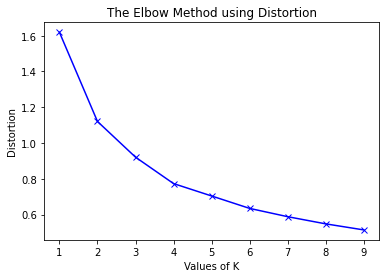

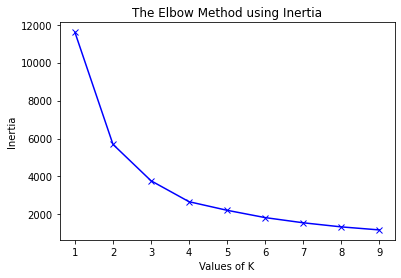

In [44]:
#### Use elbow method to find best number of clusters
distortions = [] 
inertias = []
K=range(1, 10)

for n_cluster in K: 
    kmeanModel = KMeans(n_clusters = n_cluster, random_state = 123, max_iter = 400, n_init = 20).fit(df_rank_ss[['TotalSales',
                                                                                  'OrderCount',
                                                                                  'AvgSalesPerOrder']]) 
    kmeanModel.fit(df_rank_ss[['TotalSales', 'OrderCount', 'AvgSalesPerOrder']])
    distortions.append(sum(np.min(cdist(df_rank_ss[['TotalSales',
                                                       'OrderCount',
                                                       'AvgSalesPerOrder']],
                                        kmeanModel.cluster_centers_,
                                        'euclidean'),axis = 1)) / df_rank_ss[['TotalSales',
                                                                               'OrderCount',
                                                                               'AvgSalesPerOrder']].shape[0]) 
    inertias.append(kmeanModel.inertia_)
    print('Distortion for %i clusters: %0.3f' % (n_cluster,
                                                           distortions[n_cluster - 2]))
    print('Intertia for %i clusters: %0.3f' % (n_cluster,
                                                           inertias[n_cluster - 2]))
    print()
    
# Plot distortions
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

# Plot inertias
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

Looking at the elbow method, we need to select the number of K where the distortion/inertia starts decreasing in a linear fashion. We can either select 3/4 but I will select K = 4 as 2 out of 3 of my performance metrics select 4 as the number of clusters.

In [45]:
#KMeans model development
k = 4 #Set number of clusters to 4

kmeanModel = KMeans(n_clusters = k, max_iter = 400, random_state = 123, n_init = 20).fit(df_rank_ss[['TotalSales',
                                                                                  'OrderCount',
                                                                                  'AvgSalesPerOrder']]) 
cluster_labels_km = kmeanModel.predict(df_rank_ss[['TotalSales', 'OrderCount', 'AvgSalesPerOrder']])
cluster_centers_km = kmeanModel.cluster_centers_
df_cluster_centers_km = pd.DataFrame(cluster_centers_km,
                                  columns = ['TotalSales', 
                                           'OrderCount',
                                           'AvgSalesPerOrder'])

df_cluster_centers_km['Cluster'] = df_cluster_centers_km.index #Create a column to store which cluster they belong to
df_cluster_centers_km['TotalScore'] = df_cluster_centers_km.iloc[:, 0:-1].sum(axis=1)
#Create total column to see overall performance

c = ['b', 'r', 'g', 'y']
colors_km = [c[i] for i in cluster_labels_km]

In [46]:
#Number of observations in each cluster
pd.Series(cluster_labels_km).value_counts()

1    1064
2    1000
3     938
0     865
dtype: int64

Decently even spread of observations in each cluster

In [47]:
#Statistics of each cluster
df_cluster_centers_km

,TotalSales,OrderCount,AvgSalesPerOrder,Cluster,TotalScore
0,0.279642,0.735751,-0.605737,0,0.409656
1,-1.235126,-0.807271,-1.060505,1,-3.102902
2,1.214431,0.999420,0.913045,2,3.126896
3,-0.156699,-0.835181,0.788544,3,-0.203337


Now that we have the results of the clusters, lets look at each of them.
- Cluster 0 has good total sales and order count but it seems the average sales per order is lower. This seems like the customers who buy many products but mainly only the cheaper ones. Cheaper products could me marketed to this cluster to get them to purchase more.
---
- Cluster 1 is the one with the worst results for all three variables which means they are the ones that the store makes the least money from. Might not be worth focusing on this batch of customers as the returns do not seem very high.
---
- Cluster 2 is by far the best cluster with the highest results in all variables. This will be the customers that give you the best value so the most effort should be put into this cluster to maximize returns.
---
- Cluster 3 has low total sales and order count but we can see that their average sales per order is the second highest. This means that the customers for this cluster buys the more premium products. We can make personalized ads for the premium products towards this cluster.

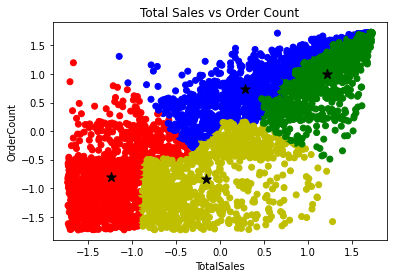

In [48]:
#Scatter of total sales vs order count
plt.scatter(df_rank_ss['TotalSales'], df_rank_ss['OrderCount'], c = colors_km)
plt.scatter(cluster_centers_km[:, 0], cluster_centers_km[:, 1], marker = '*', s = 100, c = 'black')
plt.xlabel('TotalSales')
plt.ylabel('OrderCount')
plt.title('Total Sales vs Order Count')
plt.show()

We can see that the centroids are quite good here. However, as seen in the silhouette score as well, the clusters are not as tightly packed.

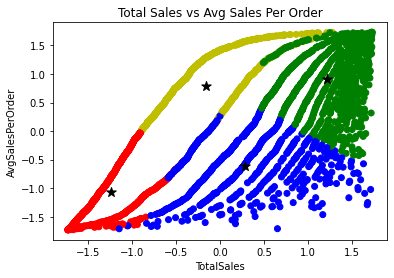

In [49]:
#Scatter of total sales vs avg sales per order
plt.scatter(df_rank_ss['TotalSales'], df_rank_ss['AvgSalesPerOrder'], c = colors_km)
plt.scatter(cluster_centers_km[:, 0], cluster_centers_km[:, 2], marker = '*', s = 100, c = 'black')
plt.xlabel('TotalSales')
plt.ylabel('AvgSalesPerOrder')
plt.title('Total Sales vs Avg Sales Per Order')
plt.show()

The clusters here are not really good as they seem to be mixed up a bit here and there. The centroids are decent except for the yellow coloured one.

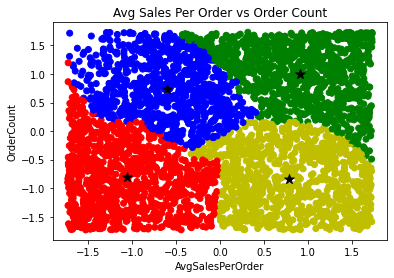

In [50]:
#Scatter of Avg Sales Per Order vs order count
plt.scatter(df_rank_ss['AvgSalesPerOrder'], df_rank_ss['OrderCount'], c = colors_km)
plt.scatter(cluster_centers_km[:, 2], cluster_centers_km[:, 1], marker = '*', s = 100, c = 'black')
plt.xlabel('AvgSalesPerOrder')
plt.ylabel('OrderCount')
plt.title('Avg Sales Per Order vs Order Count')
plt.show()

The clusters here are pretty well separated and the centroids are well placed. Would be better if the clusters was more tightly packed.

## Gaussian Mixture Models (GMM)

### Silhouette Score
Silhouette score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters. The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

Silhouette coefficient for 2 clusters: 0.102
Silhouette coefficient for 3 clusters: 0.108
Silhouette coefficient for 4 clusters: 0.261
Silhouette coefficient for 5 clusters: -0.045
Silhouette coefficient for 6 clusters: 0.230
Silhouette coefficient for 7 clusters: 0.219
Silhouette coefficient for 8 clusters: -0.114
Silhouette coefficient for 9 clusters: 0.205


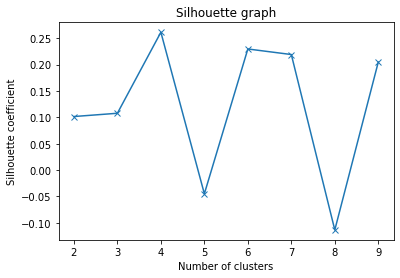


The best number of clusters using silhouette coefficient is 4 which has a score of 0.261.


In [51]:
# Calculate Silhouette coefficient to find optimal number of clusters
silhouette_gmm = []
K = range(2, 10)
for n_cluster in K:
    gmm = GaussianMixture(n_components = n_cluster,
                          random_state = 123,
                        covariance_type = 'full',
                         init_params = 'random',
                         max_iter = 400).fit(df_rank_ss[['TotalSales',
                                                  'OrderCount',
                                                  'AvgSalesPerOrder']])
    labels = gmm.predict(df_rank_ss[['TotalSales',
                                                  'OrderCount',
                                                  'AvgSalesPerOrder']])
    silhouette_avg = silhouette_score(df_rank_ss[['TotalSales',
                                                     'OrderCount',
                                                     'AvgSalesPerOrder']],
                                      labels)
    silhouette_gmm.append(silhouette_avg)
    print('Silhouette coefficient for %i clusters: %0.3f' % (n_cluster,
                                                             silhouette_avg))
    
#Plotting silhouette scores
plt.plot(K, silhouette_gmm, marker = 'x')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette graph')
plt.show()    

print()
print(f'The best number of clusters using silhouette coefficient is \
{silhouette_gmm.index(max(silhouette_gmm)) + 2} \
which has a score of {round(max(silhouette_gmm), 3)}.')

### AIC Score
The Akaike information criterion (AIC) is a mathematical method for evaluating how well a model fits the data it was generated from. The lower the score the better.

AIC Score for 2 clusters: 22169.647
AIC Score for 3 clusters: 22193.137
AIC Score for 4 clusters: 13129.155
AIC Score for 5 clusters: 22206.542
AIC Score for 6 clusters: 11757.865
AIC Score for 7 clusters: 10322.515
AIC Score for 8 clusters: 22248.289
AIC Score for 9 clusters: 7916.799


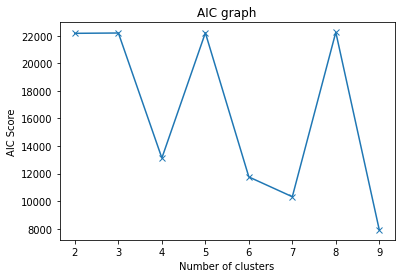


The best number of clusters using AIC score is 9 which has a score of 7916.799.


In [52]:
# Calculate AIC Score to find optimal number of clusters
AIC_gmm = []
K = range(2, 10)
for n_cluster in K:
    gmm = GaussianMixture(n_components = n_cluster,
                          random_state = 123,
                        covariance_type = 'full',
                         init_params = 'random',
                         max_iter = 400).fit(df_rank_ss[['TotalSales',
                                                  'OrderCount',
                                                  'AvgSalesPerOrder']])
    labels = gmm.predict(df_rank_ss[['TotalSales',
                                                  'OrderCount',
                                                  'AvgSalesPerOrder']])
    aic = gmm.aic(df_rank_ss[['TotalSales',
                                                  'OrderCount',
                                                  'AvgSalesPerOrder']])
    AIC_gmm.append(aic)
    print('AIC Score for %i clusters: %0.3f' % (n_cluster,
                                                             aic))
    
#Plotting silhouette scores
plt.plot(K, AIC_gmm, marker = 'x')
plt.xlabel('Number of clusters')
plt.ylabel('AIC Score')
plt.title('AIC graph')
plt.show()

print()
print(f'The best number of clusters using AIC score is \
{AIC_gmm.index(min(AIC_gmm)) + 2} \
which has a score of {round(min(AIC_gmm), 3)}.')

### BIC Score
Bayesian information criterion (BIC) is based, in part, on the likelihood function, and it is closely related to Akaike information criterion (AIC). Though BIC is always higher than AIC, lower the value of these two measures, better the model.

BIC Score for 2 clusters: 22288.592
BIC Score for 3 clusters: 22374.683
BIC Score for 4 clusters: 13373.304
BIC Score for 5 clusters: 22513.293
BIC Score for 6 clusters: 12127.219
BIC Score for 7 clusters: 10754.471
BIC Score for 8 clusters: 22742.847
BIC Score for 9 clusters: 8473.960


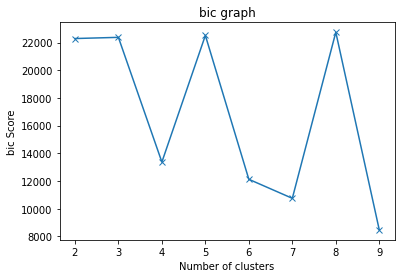


The best number of clusters using BIC score is 9 which has a score of 8473.96.


In [53]:
# Calculate bic Score to find optimal number of clusters
BIC_gmm = []
K = range(2, 10)
for n_cluster in K:
    gmm = GaussianMixture(n_components = n_cluster,
                          random_state = 123,
                        covariance_type = 'full',
                         init_params = 'random',
                         max_iter = 400).fit(df_rank_ss[['TotalSales',
                                                  'OrderCount',
                                                  'AvgSalesPerOrder']])
    labels = gmm.predict(df_rank_ss[['TotalSales',
                                                  'OrderCount',
                                                  'AvgSalesPerOrder']])
    bic = gmm.bic(df_rank_ss[['TotalSales',
                                                  'OrderCount',
                                                  'AvgSalesPerOrder']])
    BIC_gmm.append(bic)
    print('BIC Score for %i clusters: %0.3f' % (n_cluster,
                                                             bic))
    
#Plotting silhouette scores
plt.plot(K, BIC_gmm, marker = 'x')
plt.xlabel('Number of clusters')
plt.ylabel('bic Score')
plt.title('bic graph')
plt.show()

print()
print(f'The best number of clusters using BIC score is \
{BIC_gmm.index(min(BIC_gmm)) + 2} \
which has a score of {round(min(BIC_gmm), 3)}.')

After looking at the results, silhouette coefficient shows that best number of clusters are 4 while AIC and BIC shows best number of clusters are 9. I will go with 9 as the silhouette coefficient at 4 which is 0.261 does not differ too much with the one at 9 which is 0.205.

In [54]:
#GMM Model Development
k = 9 #Set number of clusters to 9
cluster_center_gmm = []

gmm = GaussianMixture(n_components = k,
                          random_state = 123,
                        covariance_type = 'full',
                         init_params = 'random',
                         max_iter = 400).fit(df_rank_ss[['TotalSales',
                                                  'OrderCount',
                                                  'AvgSalesPerOrder']])
cluster_labels_gmm = gmm.predict(df_rank_ss[['TotalSales', 'OrderCount', 'AvgSalesPerOrder']])

cluster_centers_gmm = gmm.means_
for i in range(k):
    cluster_center_gmm.append(cluster_centers_gmm[i])

df_cluster_centers_gmm = pd.DataFrame(cluster_centers_gmm,
                                  columns = ['TotalSales', 
                                           'OrderCount',
                                           'AvgSalesPerOrder'])

df_cluster_centers_gmm['Cluster'] = df_cluster_centers_gmm.index #Create a column to store which cluster they belong to
df_cluster_centers_gmm['TotalScore'] = df_cluster_centers_gmm.iloc[:, 0:-1].sum(axis=1)
#Create total column to see overall performance



c = ['b', 'r', 'g', 'y', 'c', 'lightcoral', 'orange', 'deeppink', 'antiquewhite']
colors_gmm = [c[i] for i in cluster_labels_gmm]

In [55]:
#Number of observations in each cluster
pd.Series(cluster_labels_gmm).value_counts()

1    1181
2     541
4     422
3     396
7     378
8     320
6     213
5     211
0     205
dtype: int64

Not very equal spread of observations in each cluster as cluster 1 has too many clusters. Not the most ideal but we will move ahead.

In [56]:
#Statistics of each cluster
df_cluster_centers_gmm

,TotalSales,OrderCount,AvgSalesPerOrder,Cluster,TotalScore
0,1.083690,0.178889,1.501993,0,2.764572
1,-1.090584,-1.093795,-0.464341,1,-2.648720
2,0.861785,0.846350,0.454217,2,2.162353
3,0.474335,0.950027,-0.563986,3,0.860377
4,-0.053375,-0.170144,0.174426,4,-0.049092
5,0.128389,-1.173257,1.434551,5,0.389683
6,1.383623,1.553366,-0.113259,6,2.823730
7,-0.771361,0.177498,-1.298094,7,-1.891957
8,1.304920,1.062289,1.228451,8,3.595660


Now that we have the results of the clusters, lets look at each of them. As there are too many clusters, i will divide them into similar traits.
- Cluster 0 has a good total sales and average sales per order but the order count is on the lower side. This means the customers in this customers are buying the more expensive products. Promotions towards the premium items could be given to this cluster.
---
- Cluster 1 has a bad result for all 3 variable with it being the worst cluster. It can be ignored and focused less on as there are so many clusters. However we have to take note that majority of the customers fall into this cluster.
---
- Cluster 2 has a decent result for all 3 variables. The total score also shows it is the 4th highest, a meeting could be held to think of how to improve results for this cluster.
---
- Cluster 3 has a good order count but the total sales is dissapointing and the average sales per order is the second worst. This shows that the cluster here is the one buying cheaper products at large quantities. An idea should be thought of to increase the number of orders for them to increase total sales.
---
- Cluster 4 is similar to cluster 1 but just not as bad. Similar to cluster 1, this cluster can be ignored.
---
- Cluster 5 has very low total sales and order count but the second highest average sales per order after cluster 0. We can assume that this cluster purchases even more expensive items than cluster 0 but at a very low quantity.
---
- Cluster 6 performs second best at total score due to the highest total sales and order count among all clusters. However, we take note that the average sales per order is on the lower side. This means this is the cluster with the highest purchasing quantity of the cheaper products. This cluster should be one of the main focuses of the retail store to increase overall revenue.
---
- Cluster 7 performs badly in total sales and average sales per order, and it only has a below average order count. This cluster can be ignored as well.
---
- Cluster 8 is the best cluster just looking at the total score. It performs well in all variables. Just these facts tell that this will be one of the main clusters to pay attention to.

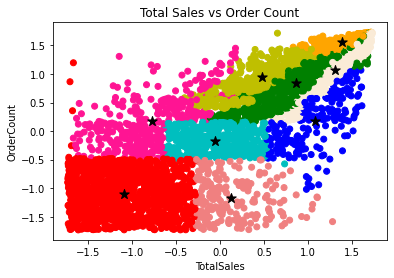

In [57]:
#Scatter of total sales vs order count
plt.scatter(df_rank_ss['TotalSales'], df_rank_ss['OrderCount'], c = colors_gmm)
plt.scatter(cluster_centers_gmm[:, 0], cluster_centers_gmm[:, 1], marker = '*', s = 100, c = 'black')
plt.xlabel('TotalSales')
plt.ylabel('OrderCount')
plt.title('Total Sales vs Order Count')
plt.show()

We can see that the centroids are quite good here. However, as seen in the scatter above, the clusters are not tightly packed as some of them are entering another clusters area.

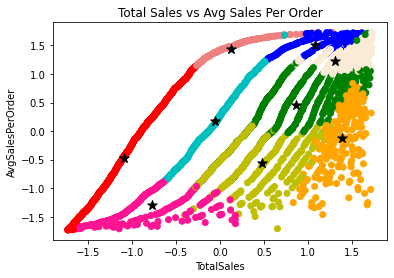

In [58]:
#Scatter of total sales vs avg sales per order
plt.scatter(df_rank_ss['TotalSales'], df_rank_ss['AvgSalesPerOrder'], c = colors_gmm)
plt.scatter(cluster_centers_gmm[:, 0], cluster_centers_gmm[:, 2], marker = '*', s = 100, c = 'black')
plt.xlabel('TotalSales')
plt.ylabel('AvgSalesPerOrder')
plt.title('Total Sales vs Avg Sales Per Order')
plt.show()

The centroids here are quite well placed but the clusters seem to mix into each other, as can be seen in the light blue, pink, and green entering each others territory.

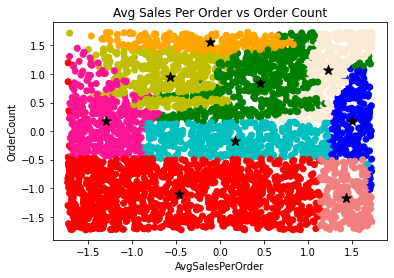

In [59]:
#Scatter of Avg Sales Per Order vs order count
plt.scatter(df_rank_ss['AvgSalesPerOrder'], df_rank_ss['OrderCount'], c = colors_gmm)
plt.scatter(cluster_centers_gmm[:, 2], cluster_centers_gmm[:, 1], marker = '*', s = 100, c = 'black')
plt.xlabel('AvgSalesPerOrder')
plt.ylabel('OrderCount')
plt.title('Avg Sales Per Order vs Order Count')
plt.show()

The centroids here are quite well placed but the clusters seem to mix into each other, as can be seen in almost all the clusters having some data points in another cluster.

## Agglomerative Hierarchical Clustering

### Silhouette Score
Silhouette score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters. The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

Silhouette coefficient for 2 clusters: 0.419
Silhouette coefficient for 3 clusters: 0.392
Silhouette coefficient for 4 clusters: 0.382
Silhouette coefficient for 5 clusters: 0.363
Silhouette coefficient for 6 clusters: 0.322
Silhouette coefficient for 7 clusters: 0.324
Silhouette coefficient for 8 clusters: 0.322
Silhouette coefficient for 9 clusters: 0.321


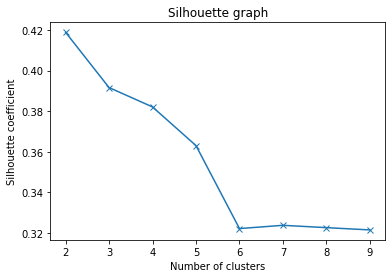


The best number of clusters using silhouette coefficient is 2 which has a score of 0.419.


In [60]:
# Calculate Silhouette coefficient to find optimal number of clusters
silhouette_agg = []
K = range(2, 10)
for n_cluster in K:
    agg = AgglomerativeClustering(n_clusters = n_cluster,
                                 metric = 'euclidean').fit(df_rank_ss[['TotalSales',
                                                  'OrderCount',
                                                  'AvgSalesPerOrder']])
    silhouette_avg = silhouette_score(df_rank_ss[['TotalSales',
                                                     'OrderCount',
                                                     'AvgSalesPerOrder']],
                                      agg.labels_)
    silhouette_agg.append(silhouette_avg)
    print('Silhouette coefficient for %i clusters: %0.3f' % (n_cluster,
                                                             silhouette_avg))

#Plotting silhouette scores
plt.plot(K, silhouette_agg, marker = 'x')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette graph')
plt.show()

print()
print(f'The best number of clusters using silhouette coefficient is \
{silhouette_agg.index(max(silhouette_agg)) + 2} \
which has a score of {round(max(silhouette_agg), 3)}.')

### Davies-Bouldin index
The Davies-Bouldin index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. Zero is the lowest possible score. Values closer to zero indicate a better partition.

Davies-Bouldin score for 2 clusters: 0.943
Davies-Bouldin score for 3 clusters: 0.881
Davies-Bouldin score for 4 clusters: 0.914
Davies-Bouldin score for 5 clusters: 0.821
Davies-Bouldin score for 6 clusters: 0.858
Davies-Bouldin score for 7 clusters: 0.912
Davies-Bouldin score for 8 clusters: 0.963
Davies-Bouldin score for 9 clusters: 0.898


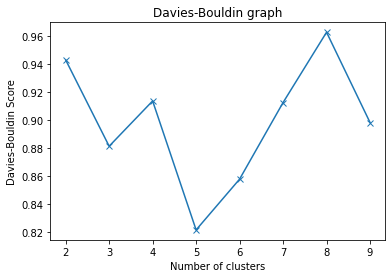


The best number of clusters using Davies-Bouldin score is 5 which has a score of 0.821.


In [61]:
# Calculate Davies-Bouldin score to find optimal number of clusters
davies_agg = []
K = range(2, 10)
for n_cluster in K:
    agg = AgglomerativeClustering(n_clusters = n_cluster,
                                 metric = 'euclidean').fit(df_rank_ss[['TotalSales',
                                                  'OrderCount',
                                                  'AvgSalesPerOrder']])
    davies_bouldin_avg = davies_bouldin_score(df_rank_ss[['TotalSales',
                                                     'OrderCount',
                                                     'AvgSalesPerOrder']],
                                            agg.labels_)
    davies_agg.append(davies_bouldin_avg)
    print('Davies-Bouldin score for %i clusters: %0.3f' % (n_cluster,
                                                           davies_bouldin_avg))

#Plotting Davies-Bouldin scores
plt.plot(K, davies_agg, marker = 'x')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin graph')
plt.show()
    
print()
print(f'The best number of clusters using Davies-Bouldin score is \
{davies_agg.index(min(davies_agg)) + 2} \
which has a score of {round(min(davies_agg), 3)}.')

### Calinski-Harabasz score
A higher Calinski-Harabasz score relates to a model with better defined clusters.

Calinski-Harabasz score for 2 clusters: 3666.227
Calinski-Harabasz score for 3 clusters: 3595.371
Calinski-Harabasz score for 4 clusters: 3902.440
Calinski-Harabasz score for 5 clusters: 3540.468
Calinski-Harabasz score for 6 clusters: 3458.805
Calinski-Harabasz score for 7 clusters: 3456.158
Calinski-Harabasz score for 8 clusters: 3550.346
Calinski-Harabasz score for 9 clusters: 3536.627


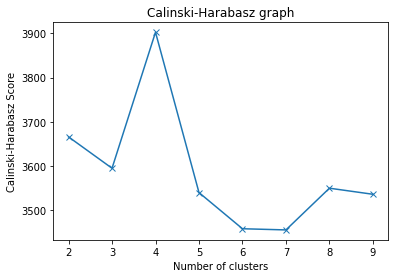


The best number of clusters using Calinski-Harabasz score is 4 which has a score of 3902.44.


In [62]:
# Calculate Calinski-Harabasz score to find optimal number of clusters
calinski_agg = []
K = range(2, 10)
for n_cluster in K:
    agg = AgglomerativeClustering(n_clusters = n_cluster,
                                 metric = 'euclidean').fit(df_rank_ss[['TotalSales',
                                                  'OrderCount',
                                                  'AvgSalesPerOrder']])
    calinski_harabasz_avg = calinski_harabasz_score(df_rank_ss[['TotalSales',
                                                     'OrderCount',
                                                     'AvgSalesPerOrder']],
                                            agg.labels_)
    calinski_agg.append(calinski_harabasz_avg)
    print('Calinski-Harabasz score for %i clusters: %0.3f' % (n_cluster,
                                                           calinski_harabasz_avg))
    
#Plotting Calinski-Harabasz scores
plt.plot(K, calinski_agg, marker = 'x')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz graph')
plt.show()

print()
print(f'The best number of clusters using Calinski-Harabasz score is \
{calinski_agg.index(max(calinski_agg)) + 2} \
which has a score of {round(max(calinski_agg), 3)}.')

Looking at the overall results, silhouette recommends 2, davies recommends 5 and calinski recommends 4. I will go with the number of clusters as 4, as they are performing decently well in the other 2 evaluations as well.

In [63]:
#Agglomerative Hierarchical Clustering model development
k = 4 #Set number of clusters to 4
agg = AgglomerativeClustering(n_clusters = k,
                                 metric = 'euclidean').fit(df_rank_ss[['TotalSales',
                                                  'OrderCount',
                                                  'AvgSalesPerOrder']])
cluster_labels_agg = agg.labels_
cluster_centers_agg = df_rank_ss.groupby(cluster_labels_agg).mean()

df_cluster_centers_agg = pd.DataFrame(cluster_centers_agg,
                                  columns = ['TotalSales', 
                                           'OrderCount',
                                           'AvgSalesPerOrder'])

df_cluster_centers_agg['Cluster'] = df_cluster_centers_agg.index #Create a column to store which cluster they belong to
df_cluster_centers_agg['TotalScore'] = df_cluster_centers_agg.iloc[:, 0:-1].sum(axis=1)
#Create total column to see overall performance

c = ['b', 'r', 'g', 'y']
colors_agg = [c[i] for i in cluster_labels_agg]

In [64]:
#Number of observations in each cluster
pd.Series(cluster_labels_agg).value_counts()

1    1112
3     937
0     909
2     909
dtype: int64

The spread of the clusters here seem quite good, just that cluster 1 has slightly more number of observations.

In [65]:
#Statistics of each cluster
df_cluster_centers_agg

,TotalSales,OrderCount,AvgSalesPerOrder,Cluster,TotalScore
0,1.132558,0.776232,1.105404,0,3.014194
1,-1.186804,-0.704818,-1.091340,1,-2.982963
2,-0.292864,-0.885188,0.630431,2,-0.547620
3,0.593858,0.942154,-0.388798,3,1.147214


Now that we have the results of the clusters, lets look at each of them.
- Cluster 0 is by far the best cluster with the highest results in all variables. This will be the customers that give you the best value so the most effort should be put into this cluster to maximize returns.
---
- Cluster 1 is the one with the worst results for all three variables which means they are the ones that the store makes the least money from. Might not be worth focusing on this batch of customers as the returns do not seem very high.
---
- Cluster 2 has low total sales and order count but we can see that their average sales per order is the second highest. This means that the customers for this cluster buys the more premium products. We can make personalized ads for the premium products towards this cluster.
---
- Cluster 3 has good total sales and order count but it seems the average sales per order is lower. This seems like the customers who buy many products but mainly only the cheaper ones. Cheaper products could me marketed to this cluster to get them to purchase more.

The results of the Agglomerative Hierarchical Clustering is similar to that of KMeans.

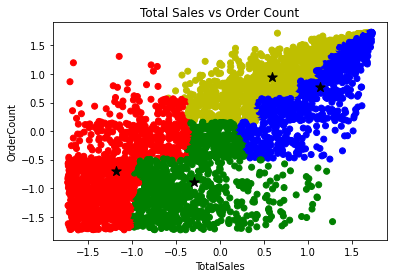

In [66]:
#Scatter of total sales vs order count
plt.scatter(df_rank_ss['TotalSales'], df_rank_ss['OrderCount'], c = colors_agg)
plt.scatter(df_cluster_centers_agg['TotalSales'], df_cluster_centers_agg['OrderCount'], marker = '*', s = 100, c = 'black')
plt.xlabel('TotalSales')
plt.ylabel('OrderCount')
plt.title('Total Sales vs Order Count')
plt.show()

The centroids here are quite good except for the blue one compared to the KMeans where all the centroids were good. However, the clusters are still not as tightly packed as we would like.

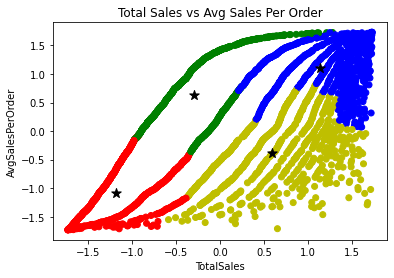

In [67]:
#Scatter of total sales vs avg sales per order
plt.scatter(df_rank_ss['TotalSales'], df_rank_ss['AvgSalesPerOrder'], c = colors_agg)
plt.scatter(df_cluster_centers_agg['TotalSales'], df_cluster_centers_agg['AvgSalesPerOrder'], marker = '*', s = 100, c = 'black')
plt.xlabel('TotalSales')
plt.ylabel('AvgSalesPerOrder')
plt.title('Total Sales vs Avg Sales Per Order')
plt.show()

The clusters here are not really good as they seem to be mixed up a bit here and there. The centroids for the green one is not very good as well.

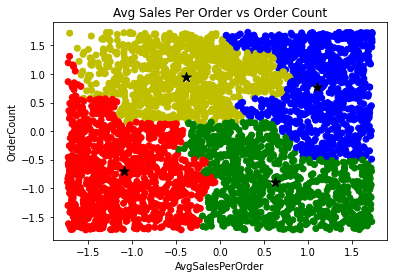

In [68]:
#Scatter of Avg Sales Per Order vs order count
plt.scatter(df_rank_ss['AvgSalesPerOrder'], df_rank_ss['OrderCount'], c = colors_agg)
plt.scatter(df_cluster_centers_agg['AvgSalesPerOrder'], df_cluster_centers_agg['OrderCount'], marker = '*', s = 100, c = 'black')
plt.xlabel('AvgSalesPerOrder')
plt.ylabel('OrderCount')
plt.title('Avg Sales Per Order vs Order Count')
plt.show()

The clusters here are pretty well separated and the centroids are well placed. Would be better if the clusters was more tightly packed.

## BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies)

### Silhouette Score
Silhouette score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters. The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

Silhouette coefficient for 2 clusters: 0.383
Silhouette coefficient for 3 clusters: 0.397
Silhouette coefficient for 4 clusters: 0.377
Silhouette coefficient for 5 clusters: 0.338
Silhouette coefficient for 6 clusters: 0.344
Silhouette coefficient for 7 clusters: 0.333
Silhouette coefficient for 8 clusters: 0.321
Silhouette coefficient for 9 clusters: 0.312


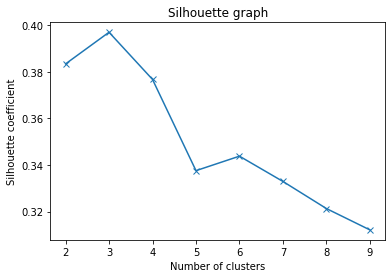


The best number of clusters using silhouette coefficient is 3 which has a score of 0.397.


In [69]:
# Calculate Silhouette coefficient to find optimal number of clusters
silhouette_bir = []
K = range(2, 10)
for n_cluster in K:
    bir = Birch(n_clusters = n_cluster,
               compute_labels = True).fit(df_rank_ss[['TotalSales',
                                                  'OrderCount',
                                                  'AvgSalesPerOrder']])
    silhouette_avg = silhouette_score(df_rank_ss[['TotalSales',
                                                     'OrderCount',
                                                     'AvgSalesPerOrder']],
                                      bir.labels_)
    silhouette_bir.append(silhouette_avg)
    print('Silhouette coefficient for %i clusters: %0.3f' % (n_cluster,
                                                             silhouette_avg))

#Plotting silhouette scores
plt.plot(K, silhouette_bir, marker = 'x')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette graph')
plt.show()

print()
print(f'The best number of clusters using silhouette coefficient is \
{silhouette_bir.index(max(silhouette_bir)) + 2} \
which has a score of {round(max(silhouette_bir), 3)}.')

### Davies-Bouldin index
The Davies-Bouldin index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. Zero is the lowest possible score. Values closer to zero indicate a better partition.

Davies-Bouldin score for 2 clusters: 0.900
Davies-Bouldin score for 3 clusters: 0.846
Davies-Bouldin score for 4 clusters: 0.885
Davies-Bouldin score for 5 clusters: 0.871
Davies-Bouldin score for 6 clusters: 0.907
Davies-Bouldin score for 7 clusters: 0.947
Davies-Bouldin score for 8 clusters: 0.960
Davies-Bouldin score for 9 clusters: 0.935


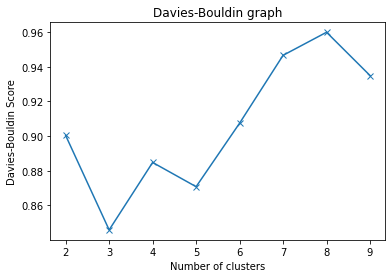


The best number of clusters using Davies-Bouldin score is 3 which has a score of 0.846.


In [70]:
# Calculate Davies-Bouldin score to find optimal number of clusters
davies_bir = []
K = range(2, 10)
for n_cluster in K:
    bir = Birch(n_clusters = n_cluster,
               compute_labels = True).fit(df_rank_ss[['TotalSales',
                                                  'OrderCount',
                                                  'AvgSalesPerOrder']])
    davies_bouldin_avg = davies_bouldin_score(df_rank_ss[['TotalSales',
                                                     'OrderCount',
                                                     'AvgSalesPerOrder']],
                                            bir.labels_)
    davies_bir.append(davies_bouldin_avg)
    print('Davies-Bouldin score for %i clusters: %0.3f' % (n_cluster,
                                                           davies_bouldin_avg))

#Plotting Davies-Bouldin scores
plt.plot(K, davies_bir, marker = 'x')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin graph')
plt.show()
    
print()
print(f'The best number of clusters using Davies-Bouldin score is \
{davies_bir.index(min(davies_bir)) + 2} \
which has a score of {round(min(davies_bir), 3)}.')

Calinski-Harabasz score for 2 clusters: 2979.220
Calinski-Harabasz score for 3 clusters: 3581.725
Calinski-Harabasz score for 4 clusters: 3713.342
Calinski-Harabasz score for 5 clusters: 3421.821
Calinski-Harabasz score for 6 clusters: 3601.903
Calinski-Harabasz score for 7 clusters: 3545.718
Calinski-Harabasz score for 8 clusters: 3544.200
Calinski-Harabasz score for 9 clusters: 3460.212


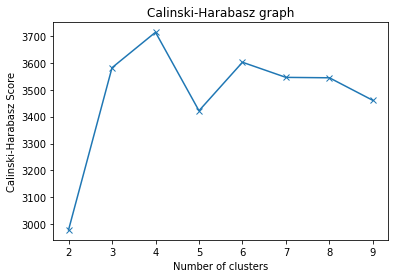


The best number of clusters using Calinski-Harabasz score is 4 which has a score of 3713.342.


In [71]:
# Calculate Calinski-Harabasz score to find optimal number of clusters
calinski_bir = []
K = range(2, 10)
for n_cluster in K:
    bir = Birch(n_clusters = n_cluster,
               compute_labels = True).fit(df_rank_ss[['TotalSales',
                                                  'OrderCount',
                                                  'AvgSalesPerOrder']])
    calinski_harabasz_avg = calinski_harabasz_score(df_rank_ss[['TotalSales',
                                                     'OrderCount',
                                                     'AvgSalesPerOrder']],
                                            bir.labels_)
    calinski_bir.append(calinski_harabasz_avg)
    print('Calinski-Harabasz score for %i clusters: %0.3f' % (n_cluster,
                                                           calinski_harabasz_avg))
    
#Plotting Calinski-Harabasz scores
plt.plot(K, calinski_bir, marker = 'x')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz graph')
plt.show()

print()
print(f'The best number of clusters using Calinski-Harabasz score is \
{calinski_bir.index(max(calinski_bir)) + 2} \
which has a score of {round(max(calinski_bir), 3)}.')

As 2 out of 3 of the evaluation methods suggest 3 for optimal number of clusters, I will use 3 as the number of clusters. Even for Calinski, 3 is the second best result for number of clusters.

In [72]:
#BIRCH model development
k = 3 #Set number of clusters to 4

bir = Birch(n_clusters = k,
               compute_labels = True).fit(df_rank_ss[['TotalSales',
                                                  'OrderCount',
                                                  'AvgSalesPerOrder']])
cluster_labels_bir = bir.labels_
cluster_centers_bir = df_rank_ss.groupby(cluster_labels_bir).mean()

df_cluster_centers_bir = pd.DataFrame(cluster_centers_bir,
                                  columns = ['TotalSales', 
                                           'OrderCount',
                                           'AvgSalesPerOrder'])

df_cluster_centers_bir['Cluster'] = df_cluster_centers_bir.index #Create a column to store which cluster they belong to
df_cluster_centers_bir['TotalScore'] = df_cluster_centers_bir.iloc[:, 0:-1].sum(axis=1)
#Create total column to see overall performance

c = ['b', 'r', 'g', 'y']
colors_bir = [c[i] for i in cluster_labels_bir]

In [73]:
#Number of observations in each cluster
pd.Series(cluster_labels_bir).value_counts()

0    1832
1    1241
2     794
dtype: int64

The clusters are quite badly distributed with cluster 0 having too many and cluster 2 having too little observations.

In [74]:
#Statistics of each cluster
df_cluster_centers_bir

,TotalSales,OrderCount,AvgSalesPerOrder,Cluster,TotalScore
0,0.833517,0.836778,0.331072,0,2.001367
1,-1.113982,-0.635830,-1.057370,1,-2.807182
2,-0.182055,-0.936916,0.888755,2,-0.230216


Now that we have the results of the clusters, lets look at each of them.
- Cluster 0 is by far the best cluster with the highest results in all variables except average sales per order. This will be the customers that give you the best value so the most effort should be put into this cluster to maximize returns.
---
- Cluster 1 is the one with the worst results for all three variables which means they are the ones that the store makes the least money from. Might not be worth focusing on this batch of customers as the returns do not seem very high.
---
- Cluster 2 has low total sales and order count but we can see that their average sales per order is the second highest. This means that the customers for this cluster buys the more premium products. We can make personalized ads for the premium products towards this cluster.

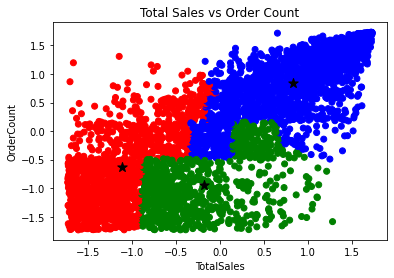

In [75]:
#Scatter of total sales vs order count
plt.scatter(df_rank_ss['TotalSales'], df_rank_ss['OrderCount'], c = colors_bir)
plt.scatter(df_cluster_centers_bir['TotalSales'], df_cluster_centers_bir['OrderCount'], marker = '*', s = 100, c = 'black')
plt.xlabel('TotalSales')
plt.ylabel('OrderCount')
plt.title('Total Sales vs Order Count')
plt.show()

The clusters here are not too well separated as we can see them all entering each others space. The centroids for red and green are a bit near to each other.

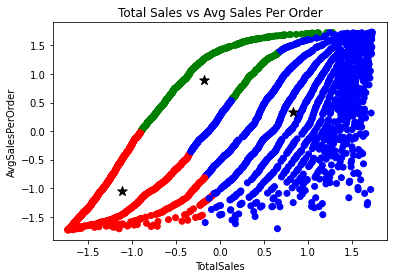

In [76]:
#Scatter of total sales vs avg sales per order
plt.scatter(df_rank_ss['TotalSales'], df_rank_ss['AvgSalesPerOrder'], c = colors_bir)
plt.scatter(df_cluster_centers_bir['TotalSales'], df_cluster_centers_bir['AvgSalesPerOrder'], marker = '*', s = 100, c = 'black')
plt.xlabel('TotalSales')
plt.ylabel('AvgSalesPerOrder')
plt.title('Total Sales vs Avg Sales Per Order')
plt.show()

The clusters here are similar as above where they enter each others space as well. Centroids here are decent.

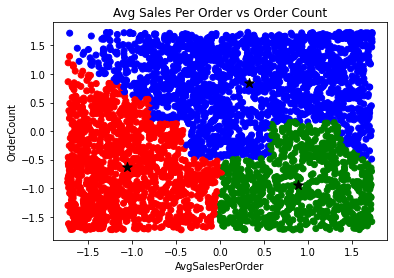

In [77]:
#Scatter of Avg Sales Per Order vs order count
plt.scatter(df_rank_ss['AvgSalesPerOrder'], df_rank_ss['OrderCount'], c = colors_bir)
plt.scatter(df_cluster_centers_bir['AvgSalesPerOrder'], df_cluster_centers_bir['OrderCount'], marker = '*', s = 100, c = 'black')
plt.xlabel('AvgSalesPerOrder')
plt.ylabel('OrderCount')
plt.title('Avg Sales Per Order vs Order Count')
plt.show()

The clusters and centroids here look well packed and does not enter to another cluster too much.

# Model Deployment

After looking at all 4 of the models, the KMeans model looks to perform the best to me, therefore I will pick that model to deploy.

In [78]:
filename = 'ProjectDataSet.sav'

pickle.dump(kmeanModel, open(filename, 'wb'))

In [79]:
loaded_model = pickle.load(open(filename, 'rb'))

In [80]:
TotalSales = 0.5
OrderCount = 0
AvgSalesPerOrder = 0.8
prediction = loaded_model.predict([[TotalSales, OrderCount, AvgSalesPerOrder]])

print(prediction)

if(prediction[0] == 0):
    print("Cheaper products")
elif(prediction[0] == 1):
        print("Ignore this group")
elif(prediction[0] == 2):
        print("Best group")
elif(prediction[0] == 3):
        print("Premium products")

[3]
Premium products


In [81]:
filename = 'ProjectDataSet.sav'
loaded_model = pickle.load(open(filename, 'rb'))

app = Flask(__name__)

@app.route('/ProjectDataSet/v1/predict', methods = ['POST'])
def predict():
    features = request.json
    features_list = [features["TotalSales"],
                    features["OrderCount"],
                    features["AvgSalesPerOrder"]]
    prediction = loaded_model.predict([features_list])
    
    response = {}
    response['prediction'] = int(prediction[0])
    return jsonify(response)

if __name__ == '__main__':
    app.run(host = '0.0.0.0', port = 5000)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)


In [ ]:
def customer_cluster(TotalSales, OrderCount, AvgSalesPerOrder):
    url = 'http://127.0.0.1:5000/ProjectDataSet/v1/predict'
    data = {"TotalSales": TotalSales, "OrderCount": OrderCount, "AvgSalesPerOrder": AvgSalesPerOrder}
    data_json = json.dumps(data)
    headers = {'Content-type':'application/json'}
    response = requests.post(url, data = data_json, headers = headers)
    result = json.loads(response.text)
    return result

if __name__ == "__main__":
    TotalSales = int(input('TotalSales?'))
    OrderCount = int(input('OrderCount?'))
    AvgSalesPerOrder = int(input('AvgSalesPerOrder?'))
    predictions = customer_cluster(TotalSales, OrderCount, AvgSalesPerOrder)
    print("Diabetic" if predictions['prediction'] == 1 else "Non Diabetic")